## 1D Occlusion

Resources: <br>
http://www.jussihuotari.com/2018/02/01/visualizing-neural-net-using-occlusion/ <br>
https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/<br>
https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps<br>
https://arxiv.org/pdf/1311.2901.pdf <br>

Check the video below to have an idea about how 1D occlusions work. <br>
In the simplest sense, in each iteration we cover a specific section of the input, and record how the output prediction probabilities change for any desired label. <br>
As the change goes higher in the negative direction, we can say that the input section associated with it has a substantial importance for the model to actually label the input with that given label. <br>
Inversely, if we cover a certain section, and the model is even more sure that the predicted label is correct (i.e. a positive change in the outcome probability), then it means that this piece has a negative impact on that particular label.

In [2]:
%%HTML
<video width="320" height="240" controls>
  <source src="occlusion_graphs/occlusion-gif.mp4" type="video/mp4">
</video>

In [1]:
import numpy as np

import pickle
def writePickle(Variable, fname):
    filename = fname +".pkl"
    f = open("pickle_vars/"+filename, 'wb')
    pickle.dump(Variable, f)
    f.close()
def readPickle(fname):
    filename = "pickle_vars/"+fname +".pkl"
    f = open(filename, 'rb')
    obj = pickle.load(f)
    f.close()
    return obj

In [2]:
# select your model
# first genre model with sub_word
predictions_file_name = "predictions_genre_model_3filter_size_112filters_120batch_40epoch"

test_labels = readPickle(str("sub_word"+"/"+"y_te_"+"genre"+"_equal"))
predictions = readPickle(str("predictions/"+predictions_file_name))
    
label_dictionary = readPickle(str("id2"+"genre"))

test_inputs = readPickle("/sub_word/x_te_genre_equal")

# vocabulary will be used later on to show input in real lyric string form
vocabulary = readPickle("/sub_word/vocabulary")
vocabulary_reversed = dict()
for key, value in vocabulary.items():
    vocabulary_reversed[value] = key
vocabulary_reversed[0] = 'PAD'

from tensorflow import keras
model = keras.models.load_model("saved_models/subword_genre_model_3filter_size_112filters_120batch_40epoch.keras")

In [4]:
# create two separate dictionaries which hold correct/incorrect label indices for each genre
genre_correct = {name:list() for name in list(label_dictionary.values())}
genre_incorrect = {name:list() for name in list(label_dictionary.values())}

counter = 0
for a, b in zip(np.argmax(predictions, axis=-1), np.argmax(test_labels, axis=-1)):
    if a == b:
        genre_correct[label_dictionary[a+1]].append(counter)
    else:
        genre_incorrect[label_dictionary[a+1]].append(counter)
    counter +=1


In [5]:
print(genre_correct)
print(genre_incorrect)

{'(Electronic) Dance': [6, 25, 35, 68, 85, 88, 92, 251, 351, 355, 449, 464, 486, 544, 575, 617, 643, 693, 755, 796, 799, 804, 828, 854, 885, 890, 904, 1020, 1030, 1109, 1161], 'Blues': [27, 59, 69, 89, 131, 145, 200, 377, 480, 519, 536, 553, 610, 660, 666, 675, 724, 785, 834, 838, 874, 927, 938, 969, 1007, 1177], 'Country': [252, 255, 259, 261, 285, 289, 308, 321, 352, 356, 359, 392, 415, 431, 441, 491, 528, 531, 532, 540, 543, 561, 646, 664, 680, 692, 710, 730, 800, 926, 932, 987, 993, 997, 1006, 1070, 1089, 1114, 1127, 1139, 1140, 1148, 1157, 1160, 1162, 1175, 1182, 1198], 'Folk': [5, 34, 56, 66, 83, 98, 105, 198, 217, 227, 319, 396, 411, 422, 607, 630, 665, 706, 764, 783, 788, 797, 841, 850, 877, 939, 964, 1002, 1027, 1033, 1093, 1122, 1128, 1138], 'Gospel&Religious': [10, 11, 29, 42, 49, 52, 91, 97, 110, 215, 231, 247, 298, 314, 322, 329, 372, 385, 388, 391, 433, 442, 460, 554, 571, 591, 597, 623, 699, 743, 789, 814, 862, 878, 916, 942, 973, 1010, 1028, 1041, 1042, 1100, 1108, 1154

In [6]:
import math
import copy

def occluder(test_labels, predictions, label_dictionary, test_inputs, model, input_index, occlusion_size):
    
    if occlusion_size % 2 == 0 or type(occlusion_size) != int:
        raise ValueError('Occlusion size must be an odd integer')      
    
    # 1. select the desired singleton test input. It might be a correctly or incorrectly labeled sample
    input_selection = test_inputs[input_index]
    
    # 2. use the model parameters to make a prediction out of your single example. store the prediction and its confidence value
    input_selection_copy1 = copy.deepcopy(input_selection) # use a deep copy to keep the original undistorted
    inp = input_selection_copy1.reshape(1, len(input_selection))
    pred = model.predict(inp)[0]
    print("Best guess is {} with {}".format(label_dictionary[np.argsort(pred)[-1]+1], pred[np.argsort(pred)[-1]]))
    best = label_dictionary[np.argsort(pred)[-1]+1]
    base_prob = pred[np.argsort(pred)[-1]]
    target = label_dictionary[np.argmax(test_labels[0], axis=-1)+1]
    
    
    # 3. depending on the occlusion_size, change input and make a new prediction with the occluded input
    # then, compare the new results with the original base probability, and record the different in a list
    
    prob_change_list = list()

    for i in range(len(input_selection)):
        input_selection_copy2 = copy.deepcopy(input_selection) # use a copy to keep the original undistorted
        size = int((occlusion_size - 1)/2)
        begin = max(i-size,0)
        end = min(i+size,len(input_selection)-1)
        
        input_selection_copy2[begin:end] = 0  # !!! THIS CONSTANT CAN BE CHANGED !!!
        inp = input_selection_copy2.reshape(1,len(input_selection))
        occluded_pred = model.predict(inp)[0]
        best_guess = label_dictionary[np.argsort(pred)[-1]+1]
        second_guess = label_dictionary[np.argsort(pred)[-2]+1]
        best_guess_prob = occluded_pred[np.argsort(occluded_pred)[-1]]
        second_guess_prob = occluded_pred[np.argsort(occluded_pred)[-2]]
        
        
        # check whether the new probabilities changed the guessing order
        if best_guess == best:
            prob_change_list.append(best_guess_prob - base_prob)
        elif second_guess == best:
            prob_change_list.append(second_guess_prob - base_prob)
        else:
            raise ValueError('The probabilities changed dramatically!!!')
    
    return prob_change_list, input_selection, input_index


In [7]:
def occluder_heatmap(change_list, input_selection, scope, input_index):
    
    # 0. check the scope value. we want a scope value as either 'full' or 'partial'. Full version also depicts
    # the padding area, by as a trade off it is exceptionally large. Partial version removes the padding area.
    if scope not in ["full", "partial"]:
        raise ValueError("The scope value must eiter be 'full' or 'partial'")
    
    # 1. convert the input from ids to real valued strings 
    input_converted = list()
    for item in input_selection:
        input_converted.append(vocabulary_reversed[item])
        
    # 2. create a dataframe out of probabilities, and a dummy dataframe for corresponding lyric string pieces
    import math
    if scope == 'full':
        size = math.ceil(math.sqrt(len(input_converted)))
    elif scope == 'partial':
        pad_index = np.where(input_selection == 0) # find the first index that padding starts
        size = math.ceil(math.sqrt(pad_index[0][0]+1))
        
    
    import pandas as pd
    
    last = change_list[-1]
    while len(change_list) < int(size*size):
        change_list.append(last)
    values = np.array(change_list[:min(size*size,len(change_list))])
    values = values.reshape(size, size)
    value_df = pd.DataFrame(values, index=range(size), columns=range(size))
    
    dummy_data = np.array([np.arange(size)]*size)
    text_df = pd.DataFrame(dummy_data, index=range(size), columns=range(size))
    # fill in the text
    for row in range(size):
        for column in range(size):
            try:
                text_df[column][row] = input_converted[(row*size)+column]
            except:
                text_df[column][row] = 'NaN'
    
    # 3. plot everything in seaborn
    import seaborn as sns
    sns.set(rc={'figure.figsize':(60,60)})
    sns.set(font_scale=2.4)
    ax = sns.heatmap(value_df, annot=text_df, fmt='', linewidths=.5, annot_kws={"size": 35, 'rotation': 45})
    figure = ax.get_figure()
    name = 'occlusion_graphs/genre_label_'+str(input_index)+'_'+scope+'.png'
    figure.savefig(name, dpi=400)

Best guess Country with 0.50546944


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/tyilmaz/.local/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


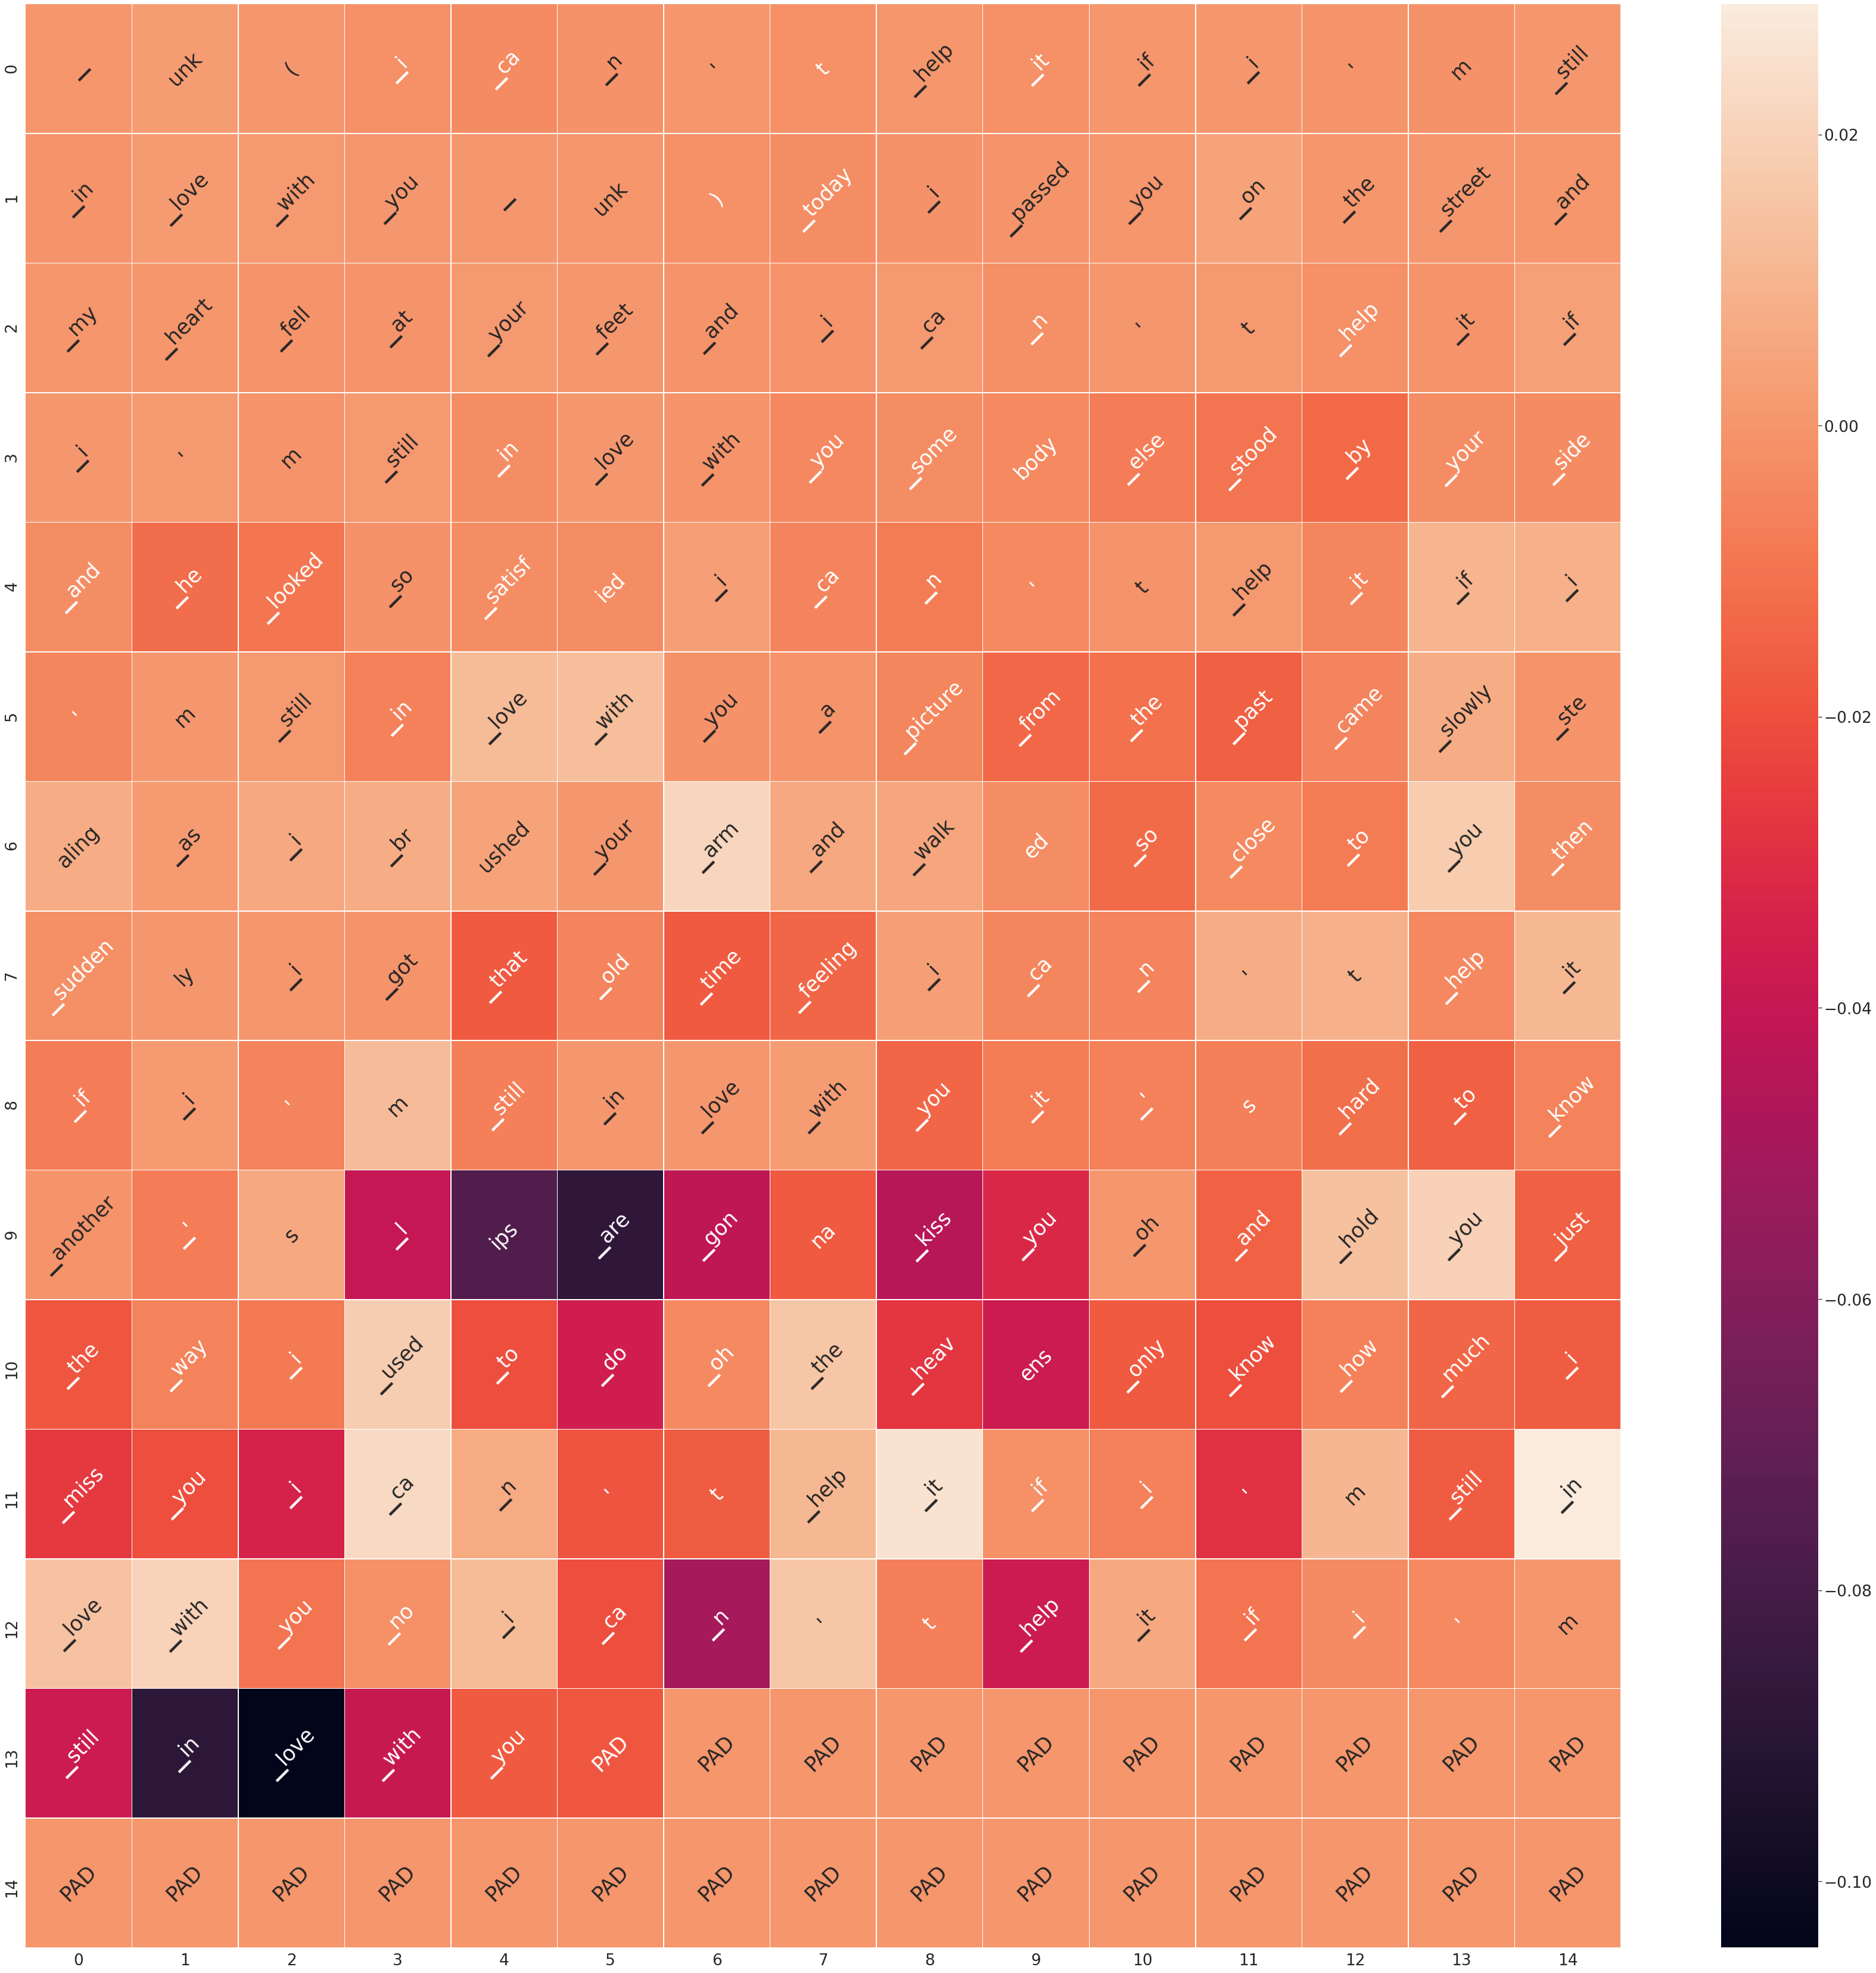

In [9]:
change_list, input_selection, index = occluder(test_labels, predictions, \
    label_dictionary, test_inputs, model, genre_correct["Country"][5], 3) # define occlusion size, input index number an other arguments

occluder_heatmap(change_list, input_selection, 'partial', index)

-----
-----
-----

## Analyzing Occlusion Results

We have seen that blocking pieces of the inputs effect the outcomes. In order to analyze the effect of input pieces on the predictions (or more specifically, individual output labels), we'll apply the following procedure: <br>
1. Select any of the output class labels
2. Among all test examples, find those whose first or second best prediction value is our selected class label
3. Run occlusions for each piece in all of the selected test examples. Record the output probability changes in a dictionary where keys are input pieces, and values are their respective output probability changes, recorded in a list. <br>
Tasks 1-3 are carried out in a seperate .py script called '<u>6.1 Occlusion_probabilities.py</u>'
4. Get the resulting probabilities dictionary and calculte the average prob. effect of each input piece.
5. Get the 20 most positively and 20 most negatively influential pieces overall, for our selected class label
6. Iterate over 1-5 on another class label for comparisons (for instance, see whether two genre labels that are confused often according to confusion matrices actually have any common input pieces)

In [24]:
def effect_by_piece(model_type, label_name, normalizer_factor):
    

    # get the probabilities file
    probabilities = readPickle(str(model_type+"/prob_change_dict_"+label_name))
    
    # turn it into an average probability dict, in the form {'piece1': 0.16, 'piece2': 0.03,...}
    avg_prob_dict = dict()
    for piece, probs in probabilities.items():
        avg_prob_dict[piece] = sum(probs)/len(probs)
    
    # find the best and worst 20 pieces in terms of their effect
    best20 = sorted(list(avg_prob_dict.values()), reverse=False)[0:20]
    least20 = sorted(list(avg_prob_dict.values()), reverse=True)[0:20]
    
    # record these pieces in a dictionary where each piece is mapped to its average probability of effect
    best20_pieces = dict()
    least20_pieces = dict()
    for prob in best20:
        for sub_word, probs in probabilities.items():
            if sum(probs)/len(probs) == prob:
                best20_pieces[sub_word] = prob
    for prob in least20:
        for sub_word, probs in probabilities.items():
            if sum(probs)/len(probs) == prob:
                least20_pieces[sub_word] = prob
                
    # start arranging data for plot mark up
    
    # collect all pieces and their probs in ascending order of effect, in two separate lists
    all_values = list(least20_pieces.values()) + list(best20_pieces.values())
    all_keys = list(least20_pieces.keys()) + list(best20_pieces.keys())
    
    # normalize the prob. values with respect to the minimum value (top positive effect) in the list.
    # this norm will be used to reflect the sizes
    norm = [float(i)*min(all_values) for i in all_values]

    # generate random spots in the graph to place bubbles
    column = [10,25,40,55,70,85]
    row = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85]
    place = list()
    for i in row:
        for j in column:
            place.append([i,j])
    
    import random
    shuffled = random.sample(place, len(place))

    # plot the data
    from plotly import graph_objs as px 
    import numpy as np 
    import plotly.offline as pyo
    pyo.init_notebook_mode()
  
    plot = px.Figure(data=[px.Scatter( 
        x = [i[0] for i in shuffled], 
        y = [i[1] for i in shuffled],
        text = all_keys,
        mode = 'markers+text', 
         marker=dict( 
       color = all_values,  
       size = [normalizer_factor*abs(i) for i in norm],
       reversescale=False,
     showscale=True)
        )]) 

    plot.update_xaxes(showticklabels=False)
    plot.update_yaxes(showticklabels=False)
    
    plot.show()

In [25]:
effect_by_piece('sub_word', 'Country', 5000000)

In [ ]:
effect_by_piece('sub_word', 'Blues', 1000000)

In [ ]:
effect_by_piece('sub_word', 'Rock', 4000000)

In [ ]:
effect_by_piece('sub_word', 'R&B', 2000000)

In [ ]:
effect_by_piece('sub_word', 'Hip Hop', 1600000)

In [ ]:
effect_by_piece('sub_word', 'Pop', 8000000)

In [ ]:
effect_by_piece('sub_word', 'Gospel&Religious', 300000)

In [ ]:
effect_by_piece('sub_word', 'Folk', 500000)

In [ ]:
effect_by_piece('sub_word', '(Electronic) Dance', 3000000)

In [ ]:
effect_by_piece('sub_word', 'Heavy Metal', 300000)

In [ ]:
effect_by_piece('sub_word', 'Punk', 2000000)

In [ ]:
effect_by_piece('sub_word', 'Jazz', 8000000)